## Importing libraries

In [63]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import probplot, moment

import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
probplot?

Signature: probplot(x, sparams=(), dist='norm', fit=True, plot=None, rvalue=False)
Docstring:
Calculate quantiles for a probability plot, and optionally show the plot.

Generates a probability plot of sample data against the quantiles of a
specified theoretical distribution (the normal distribution by default).
`probplot` optionally calculates a best-fit line for the data and plots the
results using Matplotlib or a given plot function.

Parameters
----------
x : array_like
    Sample/response data from which `probplot` creates the plot.
sparams : tuple, optional
    Distribution-specific shape parameters (shape parameters plus location
    and scale).
dist : str or stats.distributions instance, optional
    Distribution or distribution function name. The default is 'norm' for a
    normal probability plot.  Objects that look enough like a
    stats.distributions instance (i.e. they have a ``ppf`` method) are also
    accepted.
fit : bool, optional
    Fit a least-squares regression (be

In [45]:
def plot_correlogram(x: pd.Series, lags: int=None, title: str=None) -> None:
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        fig.tight_layout(pad=5)
        
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [15]:
web.DataReader?

Signature:
web.DataReader(
    name,
    data_source=None,
    start=None,
    end=None,
    retry_count=3,
    pause=0.1,
    session=None,
    api_key=None,
)
Docstring:
Imports data from a number of online sources.

Currently supports Google Finance, St. Louis FED (FRED),
and Kenneth French's data library, among others.

Parameters
----------
name : str or list of strs
    the name of the dataset. Some data sources (IEX, fred) will
    accept a list of names.
data_source: {str, None}
    the data source ("iex", "fred", "ff")
start : string, int, date, datetime, Timestamp
    left boundary for range (defaults to 1/1/2010)
end : string, int, date, datetime, Timestamp
    right boundary for range (defaults to today)
retry_count : {int, 3}
    Number of times to retry query request.
pause : {numeric, 0.001}
    Time, in seconds, to pause between consecutive queries of chunks. If
    single value given for symbol, represents the pause between retries.
session : Session, default None
    

In [5]:
industrial_production = web.DataReader("IPGMFN", "fred", "1988", "2017-12").squeeze()


In [6]:
industrial_production.head(5)

DATE
1988-01-01    55.6315
1988-02-01    56.8324
1988-03-01    57.5487
1988-04-01    57.7727
1988-05-01    57.8687
Name: IPGMFN, dtype: float64

In [7]:
components = tsa.seasonal_decompose(industrial_production, model="additive")

In [11]:
components.seasonal.head(5)

DATE
1988-01-01   -2.090507
1988-02-01   -0.579679
1988-03-01    0.747645
1988-04-01   -0.233705
1988-05-01    0.192588
Name: seasonal, dtype: float64

In [12]:
ts = industrial_production.to_frame("Original").assign(Trend = components.trend).assign(Seasonality = components.seasonal).assign(Residual=components.resid)

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>], dtype=object)

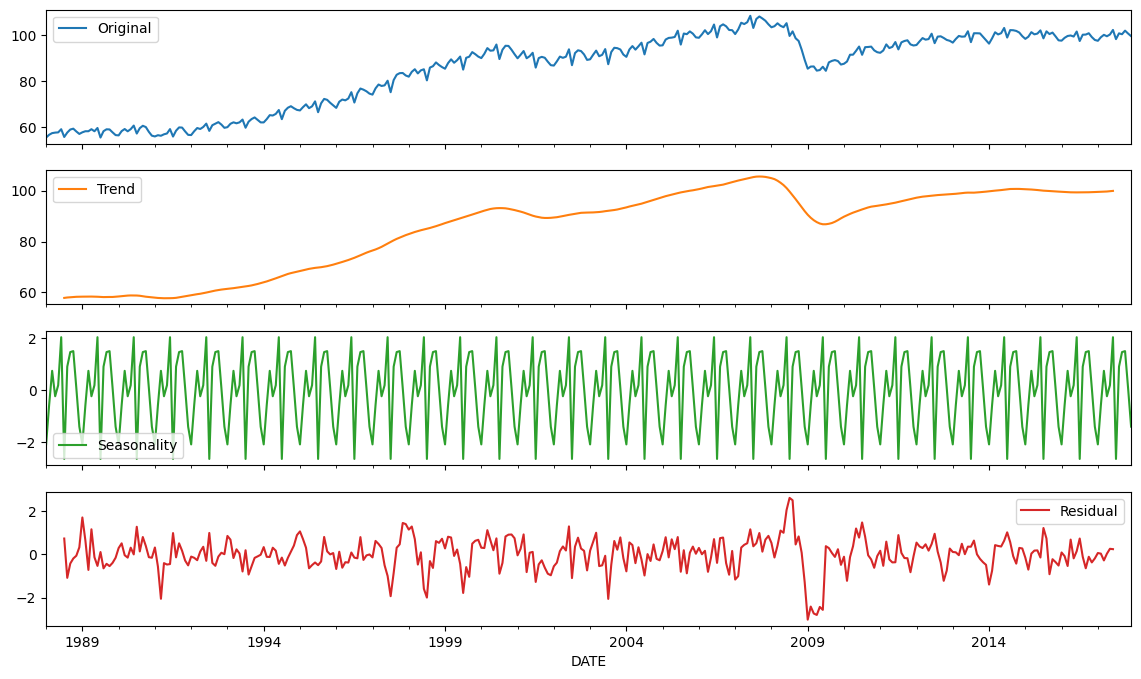

In [14]:
ts.plot(subplots=True, figsize=(14,8))

## Part 2
- https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/09_time_series_models/02_arima_models.ipynb

In [17]:
industrial_production = web.DataReader("IPGMFN", "fred", "1988", "2023-12").squeeze().dropna()
nasdaq = web.DataReader("NASDAQCOM", "fred", "1988", "2023-12").squeeze().dropna()

In [18]:
# Log transformation
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [19]:
# Differencing
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

<Axes: xlabel='DATE'>

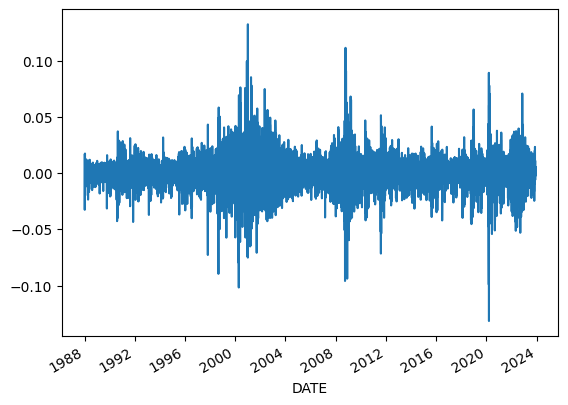

In [24]:
nasdaq_log_diff.plot(kind="line")

<Axes: xlabel='DATE'>

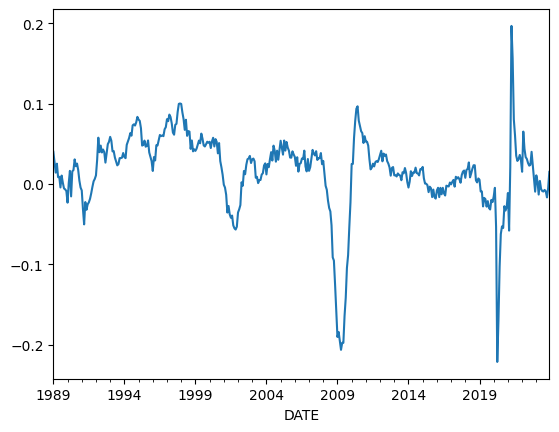

In [25]:
industrial_production_log_diff.plot(kind="line")

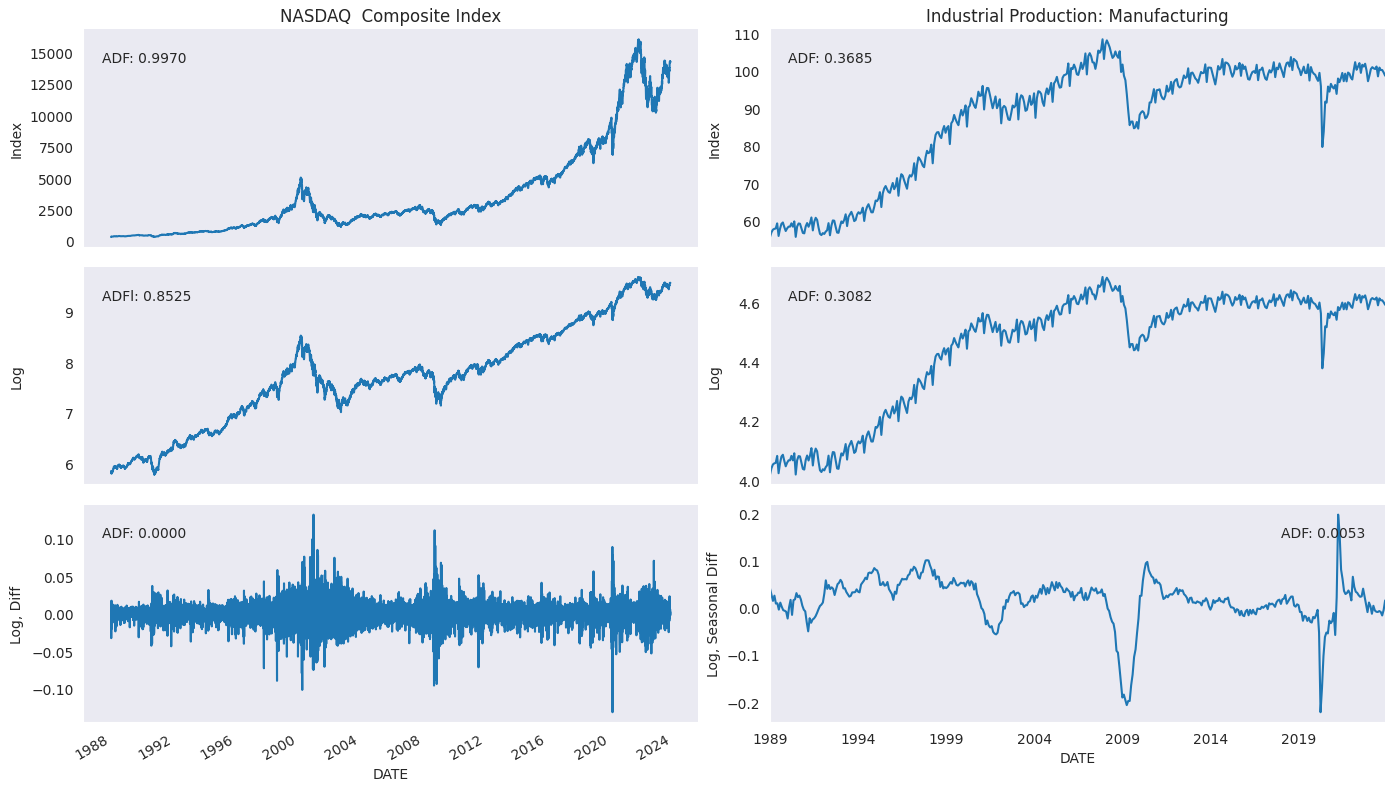

In [46]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0],
                    sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0],
                         sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                                   sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                                        sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

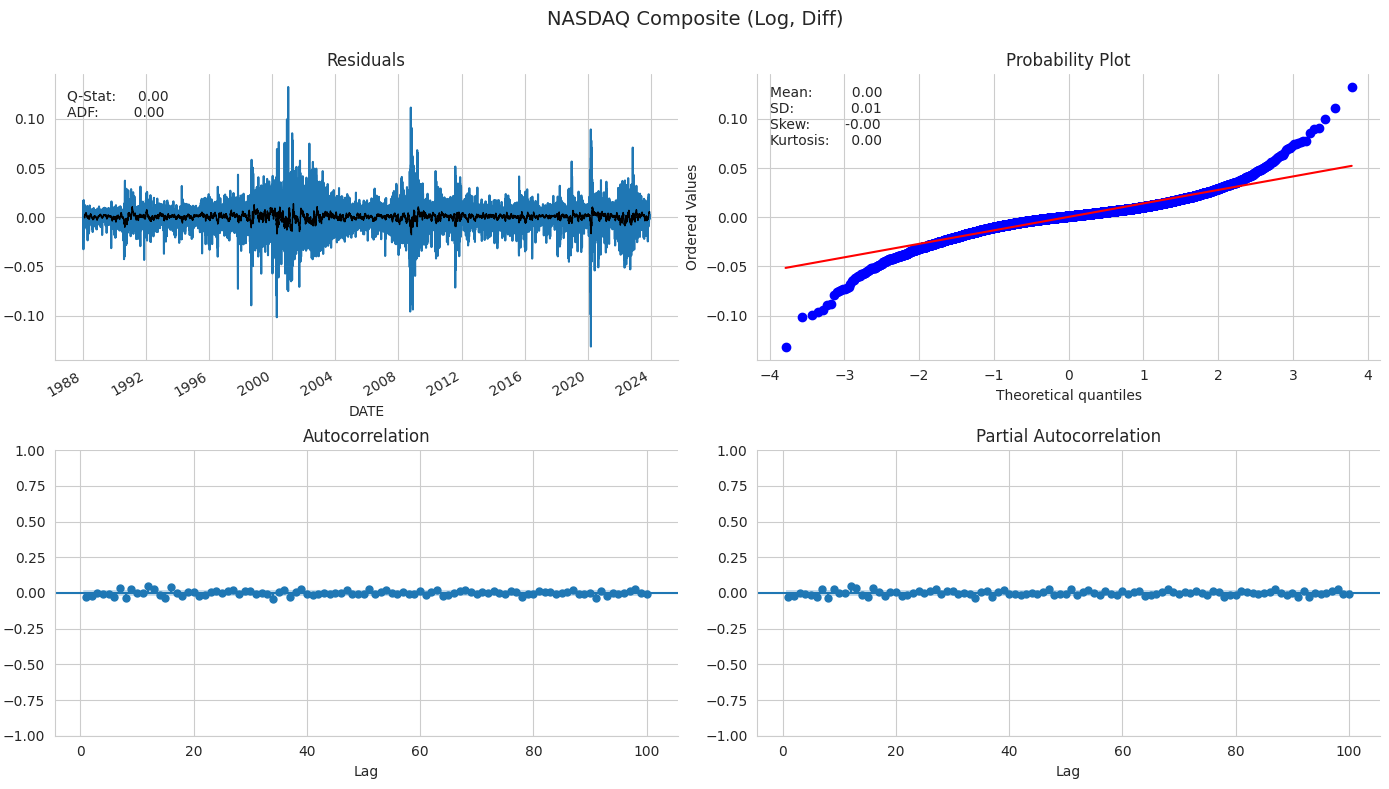

In [48]:
plot_correlogram(nasdaq_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

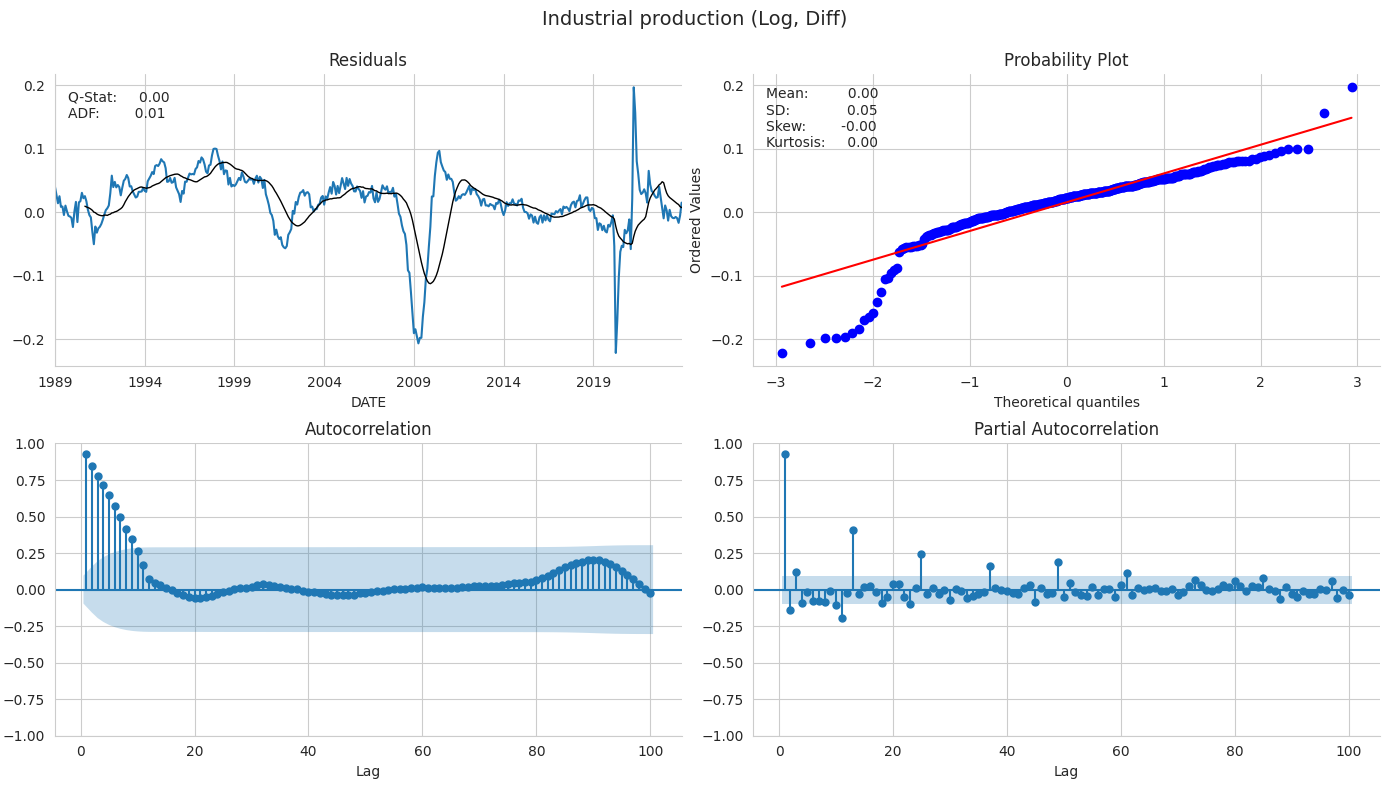

In [49]:
plot_correlogram(industrial_production_log_diff, lags=100, title='Industrial production (Log, Diff)')

## Part 3
- ARIMA and SARIMAX models

In [37]:
model2 = ARIMA(endog=nasdaq_log, order=(2, 1, 2)).fit()
model1 = ARIMA(endog=nasdaq_log_diff, order=(2,0, 2)).fit()


/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it ha

In [42]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              NASDAQCOM   No. Observations:                 9051
Model:                 ARIMA(2, 0, 2)   Log Likelihood               25614.209
Date:                Sun, 07 Jul 2024   AIC                         -51216.418
Time:                        15:46:01   BIC                         -51173.754
Sample:                             0   HQIC                        -51201.905
                               - 9051                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.701      0.007       0.000       0.001
ar.L1         -0.3316      0.265     -1.250      0.211      -0.851       0.188
ar.L2          0.2590      0.213      1.214      0.225      -0.159       0.677
ma.L1          0.3035      0.265      1.146      0.252      -0.216       0.823
ma.L2         -0.2880      0.216     -1.332      0.183      -0.712       0.136
sigma2         0.0002   1.49e-06    137.024      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18119.53
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              NASDAQCOM   No. Observations:                 9052
Model:                 ARIMA(2, 1, 2)   Log Likelihood               25609.712
Date:                Sun, 07 Jul 2024   AIC                         -51209.424
Time:                        15:45:30   BIC                         -51173.871
Sample:                             0   HQIC                        -51197.330
                               - 9052                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3238      0.289     -1.119      0.263      -0.891       0.243
ar.L2          0.1900      0.224      0.849      0.396      -0.248       0.628
ma.L1          0.2967      0.289      1.026      0.305      -0.270       0.863
ma.L2         -0.2175      0.227     -0.959      0.338      -0.662       0.227
sigma2         0.0002   1.48e-06    137.707      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18133.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
model1.params.sort_index()

ar.L1    -0.331596
ar.L2     0.258958
const     0.000413
ma.L1     0.303533
ma.L2    -0.287956
sigma2    0.000204
dtype: float64

In [39]:
model2.params.sort_index()

ar.L1    -0.323817
ar.L2     0.189990
ma.L1     0.296703
ma.L2    -0.217539
sigma2    0.000204
dtype: float64

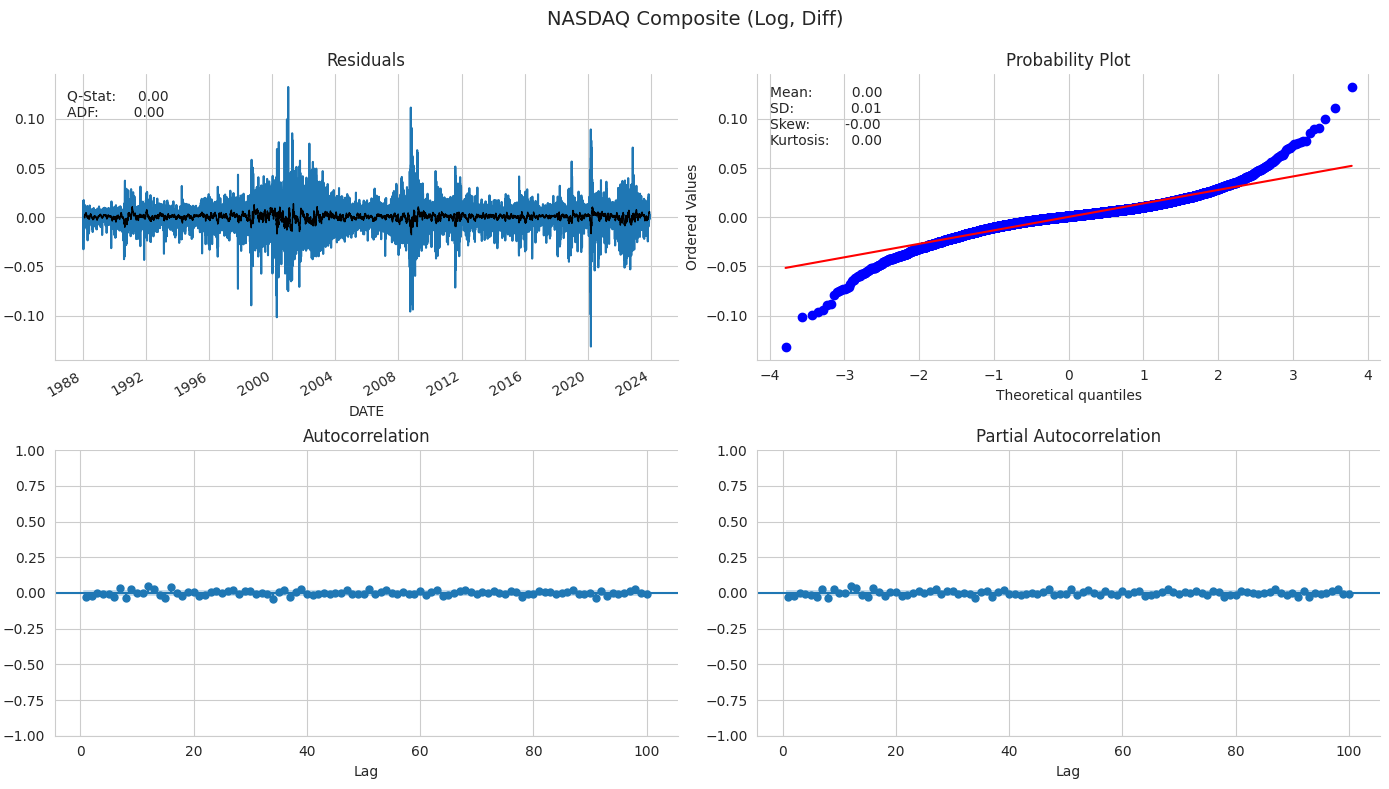

In [50]:
smodel1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
smodel2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53845D+00    |proj g|=  5.06806D-01

At iterate    5    f= -2.53847D+00    |proj g|=  2.22958D-02

At iterate   10    f= -2.53847D+00    |proj g|=  4.87443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     24      1     0     0   4.915D-03  -2.538D+00
  F =  -2.5384721775339893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/abhishekde/Desktop/Projects/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [51]:
smodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              IPGMFN   No. Observations:                  432
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 12)   Log Likelihood                1096.620
Date:                             Sun, 07 Jul 2024   AIC                          -2183.240
Time:                                     15:55:34   BIC                          -2163.039
Sample:                                 01-01-1988   HQIC                         -2175.255
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8660      0.344      2.515      0.012       0.191       1.541
ar.L2          0.0613      0.310      0.198      0.843      -0.546       0.668
ma.L1          0.2311      0.348      0.665      0.506      -0.450       0.913
ma.L2         -0.1119      0.079     -1.424      0.155      -0.266       0.042
sigma2         0.0003    7.4e-06     42.461      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             17415.05
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.74   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
smodel1.params.to_frame('SARIMAX').join(smodel2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,0.865962,0.865920
ar.L2,0.061288,0.061326
ma.L1,0.231090,0.231249
ma.L2,-0.111873,-0.111889
sigma2,0.000314,0.000314


In [57]:
range(120, len(industrial_production_log_diff))

range(120, 420)

In [60]:
model1.forecast?

Signature: model1.forecast(steps=1, signal_only=False, **kwargs)
Docstring:
forecast(self, steps=1, signal_only=False, **kwargs)

Out-of-sample forecasts

Parameters
----------
steps : int, str, or datetime, optional
    If an integer, the number of steps to forecast from the end of the
    sample. Can also be a date string to parse or a datetime type.
    However, if the dates index does not have a fixed frequency, steps
    must be an integer. Default is 1.
signal_only : bool, optional
    Whether to compute forecasts of only the "signal" component of
    the observation equation. Default is False. For example, the
    observation equation of a time-invariant model is
    :math:`y_t = d + Z \alpha_t + \varepsilon_t`, and the "signal"
    component is then :math:`Z \alpha_t`. If this argument is set to
    True, then forecasts of the "signal" :math:`Z \alpha_t` will be
    returned. Otherwise, the default is for forecasts of :math:`y_t`
    to be returned.
**kwargs
    Additional argu

In [61]:
model1.aic?

Type:        float64
String form: -51216.41816003712
File:        ~/Desktop/Projects/.venv/lib/python3.8/site-packages/numpy/__init__.py
Docstring:  
Double-precision floating-point number type, compatible with Python `float`
and C ``double``.

:Character code: ``'d'``
:Canonical name: `numpy.double`
:Alias: `numpy.float_`
:Alias on this platform (Darwin x86_64): `numpy.float64`: 64-bit precision floating-point number type: sign bit, 11 bits exponent, 52 bits mantissa.

In [69]:
# Optimizing over p, q over

train_size = 120
results = {}

# Test set
y_true = industrial_production_log_diff.iloc[train_size:]

# Looping over p,q to identify the optimal choice
for p in range(4):
    for q in range(4):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(f"p={p}, q={q}")
        
        convergence_error = stationarity_error = 0
        
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                # The series is already differenced (d=1), 
                model = ARIMA(endog=train_set, order=(p, 0, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

p=0, q=1
p=0, q=2
p=0, q=3
p=1, q=0
p=1, q=1
p=1, q=2
p=1, q=3
p=2, q=0
p=2, q=1
p=2, q=2
p=2, q=3
p=3, q=0
p=3, q=1
p=3, q=2
p=3, q=3


In [72]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.032878 -528.256886 -519.894411          0.0           0.0
  2  0.027856 -588.599730 -577.449763          0.0           0.0
  3  0.024597 -635.909605 -621.972146          0.0           0.0
1 0  0.020006 -699.835285 -691.472810          0.0           0.0
  1  0.020967 -704.083282 -692.933315          0.0           0.0
  2  0.021139 -714.983819 -701.046360          0.0           0.0
  3  0.021591 -717.326180 -700.601229          0.0           0.0
2 0  0.021618 -706.957853 -695.807886          0.0           0.0
  1  0.020527 -696.406577 -682.469118          0.0           0.0
  2  0.021166 -727.081137 -710.356186          0.0           0.0
  3  0.021301 -726.296376 -706.783934          0.0           0.0
3 0  0.020590 -719.178306 -705.240848          0.0           0.0
  1  0.021154 -719.151296 -702.426345          0.0           0.0
  2  0.020791 -724.028982 -704.516540          0.0           0.0
  3  0.020980 -724.852973 -702.553039          0.0           0.0

In [75]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
1 0  0.020006 -699.835285 -691.472810          0.0           0.0
2 1  0.020527 -696.406577 -682.469118          0.0           0.0
3 0  0.020590 -719.178306 -705.240848          0.0           0.0
  2  0.020791 -724.028982 -704.516540          0.0           0.0
1 1  0.020967 -704.083282 -692.933315          0.0           0.0

In [76]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
2 2  0.021166 -727.081137 -710.356186          0.0           0.0
  3  0.021301 -726.296376 -706.783934          0.0           0.0
3 0  0.020590 -719.178306 -705.240848          0.0           0.0
  2  0.020791 -724.028982 -704.516540          0.0           0.0
  3  0.020980 -724.852973 -702.553039          0.0           0.0

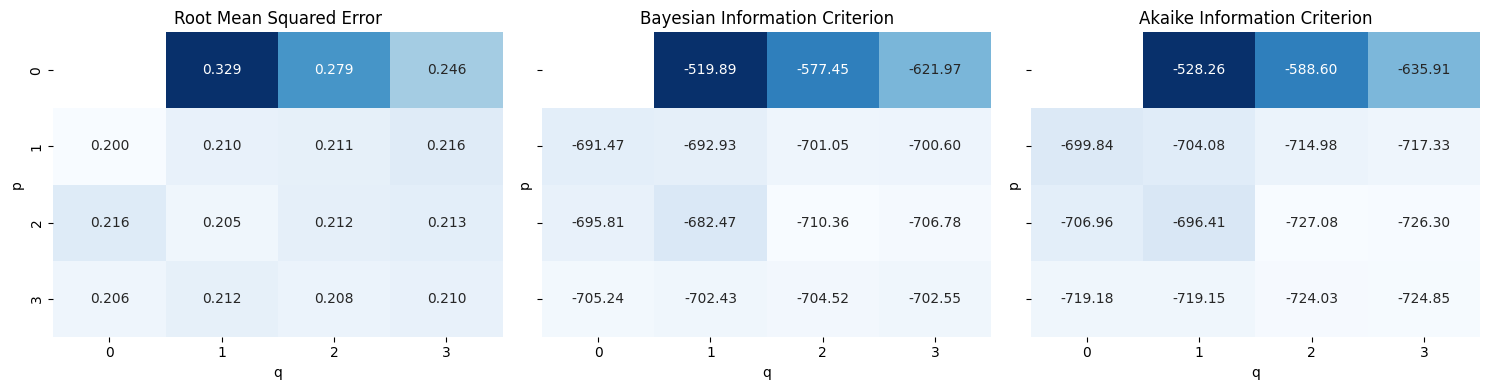

In [80]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
sns.heatmap(arma_results.AIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[2], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
axes[2].set_title('Akaike Information Criterion')
fig.tight_layout();

In [90]:
arma_results.rank(ascending=False).loc[:, ['RMSE', 'BIC']].mean(axis=1).nlargest(5)

p  q
3  0    13.0
   2    12.0
2  2    11.0
3  3    10.5
1  0    10.0
dtype: float64

In [91]:
arma_results.rank(ascending=True).loc[:, ['RMSE', 'BIC']].mean(axis=1).nsmallest(5)

p  q
3  0    3.0
   2    4.0
2  2    5.0
3  3    5.5
1  0    6.0
dtype: float64

In [92]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [93]:
best_arma_model = ARIMA(endog=industrial_production_log_diff, order=(best_p, 0, best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  420
Model:                 ARIMA(3, 0, 0)   Log Likelihood                1096.459
Date:                Sun, 07 Jul 2024   AIC                          -2182.918
Time:                        16:22:51   BIC                          -2162.716
Sample:                    01-01-1989   HQIC                         -2174.933
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.014      1.125      0.260      -0.012       0.045
ar.L1          1.0790      0.020     53.967      0.000       1.040       1.118
ar.L2         -0.2704      0.035     -7.835      0.0

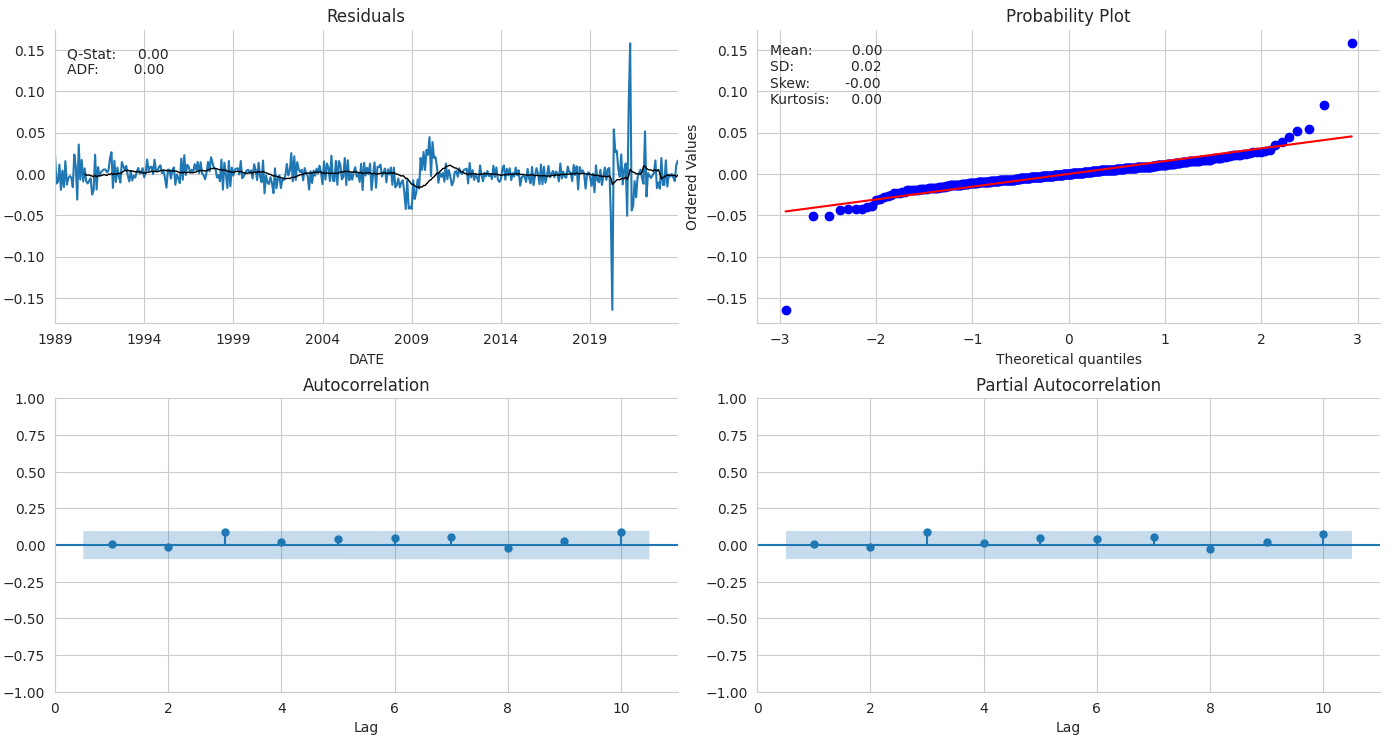

In [107]:
plot_correlogram(best_arma_model.resid)

In [104]:
# Visualize the series
y_pred = []
y_true = industrial_production_log_diff.iloc[train_size:]
for T in range(train_size, len(industrial_production_log_diff)):
    train_set = industrial_production_log_diff.iloc[T-train_size:T]
    try:
        # The series is already differenced (d=1), 
        model = ARIMA(endog=train_set, order=(best_p, 0, best_q)).fit()
    except LinAlgError:
        pass
    except ValueError:
        pass
    y_pred.append(model.forecast(steps=1)[0])

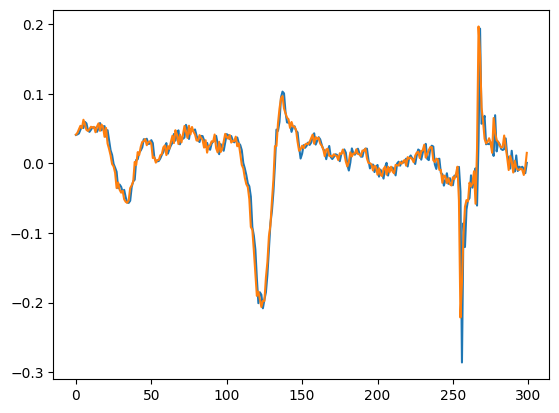

In [105]:
plt.plot(y_pred)
plt.plot(y_true.values)

#### SARIMAX models

In [114]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20257D-01    |proj g|=  9.97358D-01
  ys=-5.670E+00  -gs= 9.235E-01 BFGS update SKIPPED

At iterate    5    f= -1.61969D+00    |proj g|=  6.82462D+00

At iterate   10    f= -2.39432D+00    |proj g|=  1.99863D+00



 This problem is unconstrained.


At iterate   15    f= -2.68011D+00    |proj g|=  2.23923D+00

At iterate   20    f= -2.72359D+00    |proj g|=  7.96736D+00

At iterate   25    f= -2.78283D+00    |proj g|=  6.31539D+00

At iterate   30    f= -2.82018D+00    |proj g|=  1.74774D-02

At iterate   35    f= -2.82074D+00    |proj g|=  2.86168D-01

At iterate   40    f= -2.82079D+00    |proj g|=  1.93964D-01

At iterate   45    f= -2.82168D+00    |proj g|=  2.80008D+00

At iterate   50    f= -2.82339D+00    |proj g|=  1.14843D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      2     1     0   1.148D-01  -2.823D+00
  F =  -2.823387464285

In [115]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  420
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1185.823
Date:                              Sun, 07 Jul 2024   AIC                          -2357.645
Time:                                      16:38:05   BIC                          -2329.364
Sample:                                           0   HQIC                         -2346.467
                                              - 420                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1677      0.122      1.375      0.169      -0.071       0.407
ar.L2          0.81

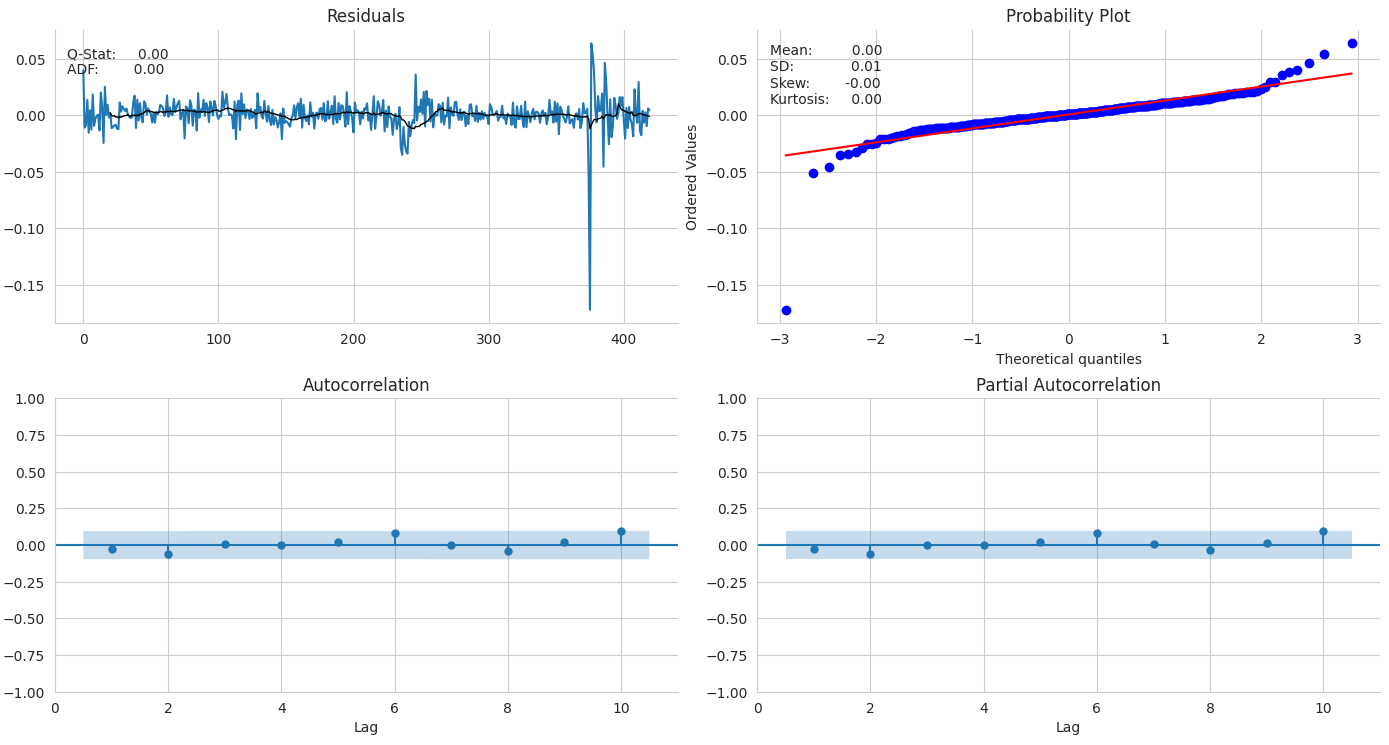

In [116]:
plot_correlogram(pd.Series(sarimax_model.resid))